In [ ]:
%cd /home/rguillaume/developpements/Publications/2024_Guillaume-Castel_PatternEffect_on_TCR/reviews

/home/rguillaume/developpements/Publications/2024_Guillaume-Castel_PatternEffect_on_TCR/reviews


In [2]:
import xarray as xr 
import lenapy 
import xesmf as xe
import numpy as np
import warnings
warnings.simplefilter('ignore',)
from xmip.preprocessing import correct_lon
import matplotlib.pyplot as plt
plt.style.use('robin')
plt.rcParams['font.family'] = 'sans'

from scipy.integrate import solve_ivp
import glob
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d
import seaborn as sns
import dask.bag as db

from xmip.preprocessing import correct_lon
from xarrayutils import xr_linregress
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
# from lenapy.plotting import plot_timeseries_uncertainty
import cmcrameri.cm as cmc 
import cmocean.cm as cmo
color_pattern = 'C1'
color_nopattern = 'C2'
color_total='0.7'
import os
from scipy.stats import linregress
from scipy.optimize import curve_fit
import warnings

from matplotlib.font_manager import fontManager
fontManager.addfont('../Arial.ttf')
fontManager.addfont('../Arial-bold.ttf')
plt.rcParams['font.sans-serif'] = 'Arial'
# plt.rcParams['mathtext.fontset'] = 'dejavuserif'


pica = 1/6
small_fig = 19*pica
med1_fig = 27*pica
med2_fig = 33*pica
large_fig = 39*pica

line_guide = dict(ls='-', lw=.8, color='0.7')

In [3]:
from dask.distributed import Client 
client = Client(n_workers=10)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 40,Total memory: 60.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33635,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 40
Started: Just now,Total memory: 60.00 GiB
Comm: tcp://127.0.0.1:36111,Total threads: 4
Dashboard: http://127.0.0.1:41653/status,Memory: 6.00 GiB
Nanny: tcp://127.0.0.1:46583,


In [4]:
ds = xr.open_dataset('/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/review/full_preprocessed.nc').isel(time=range(0,150))
ds = correct_lon(ds).sortby('lon')
ds['pattern_tos_1pct'] = ds['pattern_tos_1pct'].where(ds.tos_control_grid!=1)
ds_lbd = xr.open_dataset('/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/review/lbd_pi_iceSAF_correct.nc')

ds_hist = xr.open_dataset('/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/outputs/historical_pattern/dRp_hist_all_model.nc')
ds_hist = (ds_hist - ds_hist.isel(time=range(10)).mean('time'))
ds_hist_m = ds_hist.mean('member_id')


In [5]:
gf_directory = '/projets/EMC2/data/Models/GFMIP/preliminary_spatial_feedbacks-main/data/'
list_gf_models = os.listdir(gf_directory)


list_gf_regridded = []
for model in tqdm(list_gf_models):
    with xr.open_dataset(f"{gf_directory}/{model}") as ds_raw:
        if "spatial_feedbacks_from_both" in ds_raw.variables:
            data = ds_raw.spatial_feedbacks_from_both
        else:
            data = ds_raw.spatial_feedbacks_from_warming
    # weights = xr.ones_like(data)*np.cos(np.deg2rad(data.latitude))
    # weights = weights/weights.sum(['longitude','latitude'])
    # data = data*weights
    data = data.rename(longitude='lon',latitude='lat')

    regridded_ds = xe.Regridder(data, ds.tos_control_grid, 'conservative_normed', periodic=True)(data).assign_coords(GF_source=model.split('.')[0])
    list_gf_regridded.append(regridded_ds)
greens_functions = xr.concat(list_gf_regridded, dim='GF_source' )
greens_functions = greens_functions.where(greens_functions!=0)
# greens_functions = greens_functions.where(greens_functions.count('GF_source')==greens_functions.count('GF_source').max())
greens_functions.attrs['units'] = 'W/m²'
greens_functions.attrs['long_name'] = "Green's functions coefficients"

  0%|          | 0/6 [00:00<?, ?it/s]

In [6]:
tos_1pct = xr.open_mfdataset('/bdd/CMIP6/CMIP/NCAR/CESM2/1pctCO2/r1i1p1f1/Omon/tos/gr/latest/*').tos.interp_like(greens_functions).resample(time='YS').mean().load()
tos_abrupt = xr.open_mfdataset('/bdd/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Omon/tos/gr/latest/*').tos.interp_like(greens_functions).resample(time='YS').mean().load()
tos_control = xr.open_mfdataset('/bdd/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Omon/tos/gr/latest/tos_Omon_CESM2_piControl_r1i1p1f1_gr_000101-009912.nc').isel(time=slice(0,360)).mean('time').tos.interp_like(greens_functions).load()

dtos_1pct = tos_1pct-tos_control
dtos_abrupt = tos_abrupt-tos_control
final_abrupt = tos_abrupt.isel(time=slice(-30,None)).mean()

In [11]:
tos_control = xr.open_mfdataset('/bdd/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Omon/tos/gr/latest/tos_Omon_CESM2_piControl_r1i1p1f1_gr_000101-009912.nc').isel(time=slice(0,360)).mean('time').tos.interp_like(greens_functions).load()

dtos_1pct = tos_1pct-tos_control
dtos_abrupt = tos_abrupt-tos_control 
final_abrupt = tos_abrupt.isel(time=slice(-30,None)).mean('time')

dtos_1pct_global = dtos_1pct.weighted(np.cos(np.deg2rad(dtos_1pct.lat))).mean(['lon','lat'])
dtos_abrupt_global = dtos_abrupt.weighted(np.cos(np.deg2rad(dtos_abrupt.lat))).mean(['lon','lat'])
pattern_1pct = dtos_1pct - dtos_1pct_global
pattern_abrupt = dtos_abrupt - dtos_abrupt_global

final_abrupt = dtos_abrupt.isel(time=slice(130,150)).mean('time')
final_abrupt_pattern = final_abrupt - dtos_abrupt_global.isel(time=slice(130,150)).mean('time')

dRp_1pct = (pattern_1pct*greens_functions).weighted(np.cos(np.deg2rad(dtos_1pct.lat))).mean(['lon','lat'])
dRp_abrupt = (pattern_abrupt*greens_functions).weighted(np.cos(np.deg2rad(dtos_1pct.lat))).mean(['lon','lat'])

dRp_final_abrupt = (final_abrupt_pattern*greens_functions).weighted(np.cos(np.deg2rad(dtos_1pct.lat))).mean(['lon','lat'])

In [12]:
-(dRp_final_abrupt/ds.lbd_u).mean('GF_source')

<xarray.DataArray (model: 12)> Size: 96B
array([0.97349881, 1.05494329, 1.3397097 , 1.75963843, 1.11446216,
       1.01861511, 0.83930993, 1.43392954, 1.45522989, 0.90951564,
       1.07059456, 0.97080156])
Coordinates:
    height   float64 8B 2.0
    degree   int64 8B 1
  * model    (model) <U15 720B 'BCC-CSM2-MR' 'CESM2' ... 'NorESM2-LM'

In [ ]:
TCR = ds.tas.sel(time=slice(61,80)).mean('time')
TCR_F = ds.integrated_tas.sel(integration_type='only_pattern', depth='surface').sel(GF_source='mean').sel(time=slice(61,80)).mean('time')


<xarray.DataArray 'integrated_tas' (model: 12)> Size: 96B
array([-0.13504893, -0.12871482, -0.17487382, -0.29941806,  0.24048214,
       -0.13776921, -0.20359247, -0.04125827, -0.40004509, -0.19437347,
       -0.04171144, -0.12592794])
Coordinates:
  * model             (model) <U15 720B 'BCC-CSM2-MR' 'CESM2' ... 'NorESM2-LM'
    GF_source         <U7 28B 'mean'
    height            float64 8B 2.0
    degree            int64 8B 1
    integration_type  <U12 48B 'only_pattern'
    depth             <U7 28B 'surface'
    Cs                (model) float64 96B ...
    Cd                (model) float64 96B ...
    gamma             (model) float64 96B ...

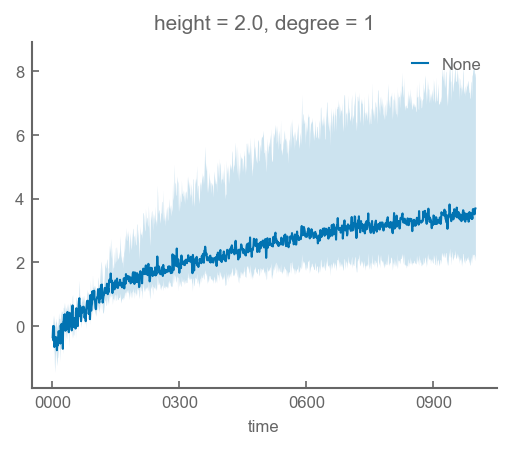

In [10]:
# dRp_1pct.lntime.plot()
dRp_abrupt.lntime.plot()

In [81]:
(dRp_1pct - dRp_abrupt.rolling(time=20).mean().rename(time='time_ref'))

<xarray.DataArray (time: 150, GF_source: 6, time_ref: 999)> Size: 7MB
array([[[        nan,         nan,         nan, ..., -5.5501941 ,
         -5.56346632, -5.58065591],
        [        nan,         nan,         nan, ..., -3.77935979,
         -3.79168945, -3.79967327],
        [        nan,         nan,         nan, ..., -1.98244082,
         -1.98394517, -1.98701613],
        [        nan,         nan,         nan, ..., -7.998561  ,
         -8.01488643, -8.03232554],
        [        nan,         nan,         nan, ..., -3.12585592,
         -3.13865972, -3.14750779],
        [        nan,         nan,         nan, ..., -2.39266796,
         -2.39980772, -2.40438066]],

       [[        nan,         nan,         nan, ..., -5.12114954,
         -5.13442176, -5.15161135],
        [        nan,         nan,         nan, ..., -3.52145959,
         -3.53378925, -3.54177306],
        [        nan,         nan,         nan, ..., -1.84945511,
         -1.85095946, -1.85403042],
        [        nan,         nan,         nan, ..., -7.68585778,
...
         -1.89051333, -1.8935843 ],
        [        nan,         nan,         nan, ..., -8.14936943,
         -8.16569486, -8.18313397],
        [        nan,         nan,         nan, ..., -3.24963889,
         -3.2624427 , -3.27129076],
        [        nan,         nan,         nan, ..., -1.66757138,
         -1.67471113, -1.67928408]],

       [[        nan,         nan,         nan, ..., -4.82955065,
         -4.84282287, -4.86001246],
        [        nan,         nan,         nan, ..., -3.53271622,
         -3.54504588, -3.55302969],
        [        nan,         nan,         nan, ..., -1.75087643,
         -1.75238078, -1.75545174],
        [        nan,         nan,         nan, ..., -8.19504401,
         -8.21136944, -8.22880855],
        [        nan,         nan,         nan, ..., -2.86988447,
         -2.88268828, -2.89153634],
        [        nan,         nan,         nan, ..., -1.54286501,
         -1.55000477, -1.55457771]]])
Coordinates:
  * time       (time) object 1kB 0001-01-01 00:00:00 ... 0150-01-01 00:00:00
    height     float64 8B 2.0
    degree     int64 8B 1
  * GF_source  (GF_source) <U7 168B 'cam5' 'gfdlam4' ... 'hadcm3' 'canesm5'
  * time_ref   (time_ref) object 8kB 0001-01-01 00:00:00 ... 0999-01-01 00:00:00

In [18]:
dRp_coarsen_abrupt

<xarray.DataArray (time: 19, GF_source: 6)> Size: 912B
array([[-0.07786899, -0.21176809,  0.14580754, -0.40571848, -0.20152848,
         0.46160198],
       [ 0.64798772,  0.43587089,  0.42944891,  0.59429559,  0.29621733,
         0.89443834],
       [ 1.52436604,  1.02829739,  0.70651875,  1.77425575,  0.81719329,
         1.24483527],
       [ 2.07969228,  1.41264109,  0.91710248,  2.70489725,  1.15818199,
         1.44558432],
       [ 2.54431152,  1.73344616,  1.08449143,  3.45914768,  1.44452007,
         1.60213493],
       [ 2.86699281,  1.95590635,  1.25706142,  4.14833012,  1.60444906,
         1.68310612],
       [ 3.20726482,  2.17497874,  1.31913421,  4.59320366,  1.79662618,
         1.77751894],
       [ 3.47594844,  2.3436289 ,  1.43457196,  5.06893536,  1.92292763,
         1.83441824],
       [ 3.66977345,  2.52856889,  1.49218196,  5.39686708,  2.08688129,
         1.90039944],
       [ 4.02864053,  2.72839828,  1.62419959,  5.9545647 ,  2.2430029 ,
         2.00929167],
       [ 4.25178622,  2.87484902,  1.66178637,  6.24889902,  2.37868341,
         2.05520394],
       [ 4.44540872,  3.03274822,  1.71922765,  6.54726491,  2.51610507,
         2.11165083],
       [ 4.61973578,  3.14457251,  1.78412123,  6.87473048,  2.6166692 ,
         2.16443507],
       [ 4.82668283,  3.32159984,  1.85015674,  7.23559777,  2.74082569,
         2.20186602],
       [ 4.95630147,  3.4158988 ,  1.87065324,  7.37764662,  2.86097566,
         2.25717607],
       [ 5.06929456,  3.43620509,  1.91968757,  7.5279757 ,  2.84927552,
         2.26786349],
       [ 5.21483268,  3.55074972,  1.91189036,  7.72611539,  2.95832005,
         2.29731302],
       [ 5.3271749 ,  3.63726154,  1.94803084,  7.84513268,  3.03543225,
         2.33760423],
       [ 5.46898936,  3.72725677,  2.04664027,  8.22177001,  3.09953668,
         2.38241836]])
Coordinates:
  * time       (time) object 152B 0025-07-02 12:00:00 ... 0925-07-02 12:00:00
    height     float64 8B 2.0
    degree     int64 8B 1
  * GF_source  (GF_source) <U7 168B 'cam5' 'gfdlam4' ... 'hadcm3' 'canesm5'

In [23]:
dRp_final_abrupt

array(-0.04824576)

In [50]:
dRp_coarsen_abrupt = dRp_abrupt.coarsen(time=50,boundary='trim').mean().mean('GF_source')
all_dRp = []
all_dTp = []
for k in range(3,19):
    dRp_final_abrupt = dRp_coarsen_abrupt.isel(time=k).values
    Rp_func =  interp1d(np.arange(0,150), (dRp_1pct - dRp_final_abrupt).mean('GF_source').values)
    
    all_dRp.append((dRp_1pct - dRp_final_abrupt).mean('GF_source').values)
    lbd_u = ds.lbd_u.values.mean()

    Cs, Cd, gamma = 5,50,0.6
    def derive(t, T):
        Ts, Td = T
        dTs = lbd_u/Cs*Ts + Rp_func(t)/Cs - gamma/Cs*(Ts-Td)
        dTd = gamma/Cd*(Ts-Td)
        return [dTs, dTd]
    sol = solve_ivp(derive, [0, 149], [0,0], t_eval=np.arange(150))
    all_dTp.append(sol.y[0])

<Axes: >

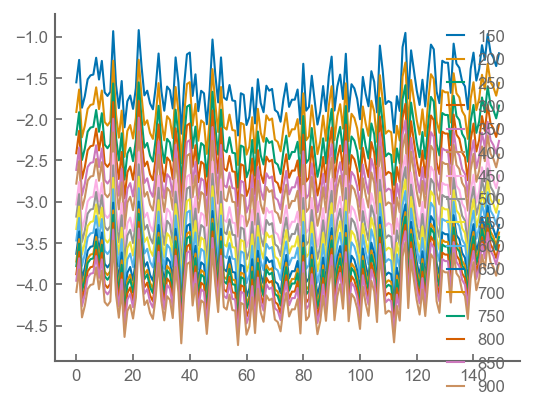

In [85]:
df_ = pd.DataFrame(all_dRp).T
df_.columns = [f"{50*(k)}" for k in range(3,19)]
df_.plot()

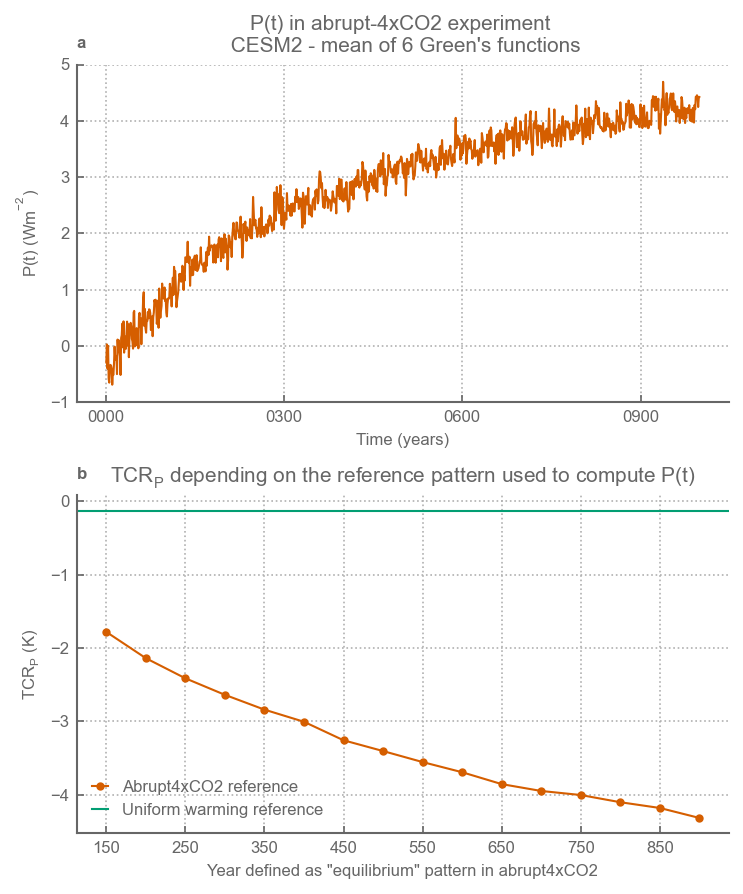

In [99]:
fig, axs = plt.subplots(2,1, figsize=(5,6))
dRp_abrupt.mean('GF_source').plot(ax=axs[0], color='C3')
(df_.loc[60:80].mean()).plot(marker='o', markersize = 3, label='Abrupt4xCO2 reference', color='C3')

axs[0].set(title="P(t) in abrupt-4xCO2 experiment \n CESM2 - mean of 6 Green's functions",
           ylim=(-1,5), xlabel='Time (years)', ylabel='P(t) (Wm$^{-2}$)')
axs[1].set(title="TCR$_P$ depending on the reference pattern used to compute P(t)",
           xlabel='Year defined as \"equilibrium\" pattern in abrupt4xCO2',
           ylabel='TCR$_P$ (K)')
axs[1].axhline(TCR_F.sel(model='CESM2'), label='Uniform warming reference', color='C2')

for ax in axs:
    ax.grid()
axs[0].text(0,1.05, 'a', transform=axs[0].transAxes, weight='bold')
axs[1].text(0,1.05, 'b', transform=axs[1].transAxes, weight='bold')
axs[1].legend()
plt.tight_layout()

<Axes: >

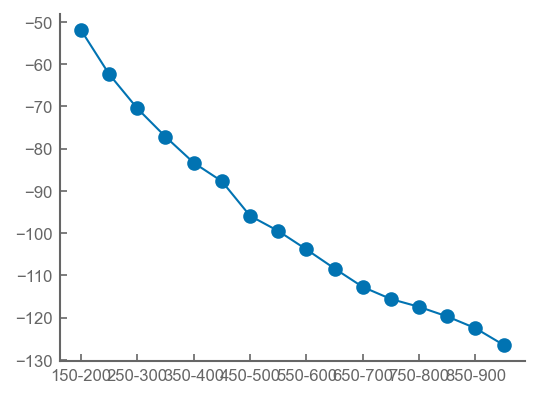

In [48]:
(df_.loc[60:80].mean()/TCR.sel(model='CESM2').values*100).plot(marker='o')

In [77]:
sol.y[0][60:80].mean()/ds.tas.sel(time=slice(60,80)).mean()

<xarray.DataArray 'tas' ()> Size: 8B
array(-0.47867001)
Coordinates:
    height   float64 8B 2.0
    degree   int64 8B 1

In [71]:
ds.tas.sel(time=slice(60,80)).mean()

<xarray.DataArray 'tas' ()> Size: 8B
array(2.0803443)
Coordinates:
    height   float64 8B 2.0
    degree   int64 8B 1

In [32]:
(final_abrupt_pattern*greens_functions).weighted(np.cos(np.deg2rad(dtos_1pct.lat))).mean(['lon','lat'])

<xarray.DataArray (GF_source: 6)> Size: 48B
array([1.84632131, 1.23598056, 0.86391702, 2.21433813, 1.01348998,
       1.38854615])
Coordinates:
    height     float64 8B 2.0
    degree     int64 8B 1
  * GF_source  (GF_source) <U7 168B 'cam5' 'gfdlam4' ... 'hadcm3' 'canesm5'

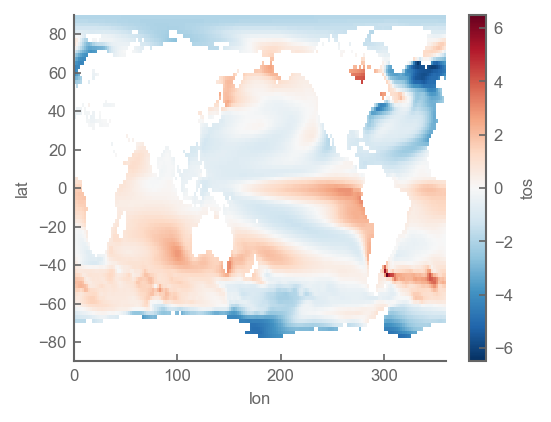

In [28]:
final_abrupt_pattern.plot()

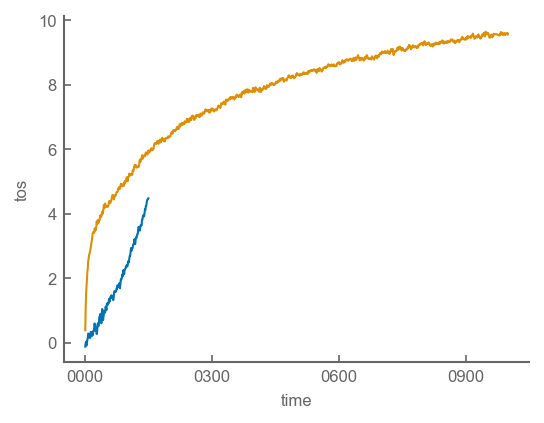

In [22]:
dtos_1pct_global.plot()
dtos_abrupt_global.plot()


In [8]:
tos_1pct

<xarray.Dataset> Size: 482MB
Dimensions:    (time: 1800, d2: 2, lat: 180, lon: 360)
Coordinates:
  * time       (time) object 14kB 0001-01-15 12:45:00 ... 0150-12-15 12:00:00
  * lat        (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Dimensions without coordinates: d2
Data variables:
    time_bnds  (time, d2) object 29kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bnds   (time, lat, d2) float64 5MB dask.array<chunksize=(600, 180, 2), meta=np.ndarray>
    lon_bnds   (time, lon, d2) float64 10MB dask.array<chunksize=(600, 360, 2), meta=np.ndarray>
    tos        (time, lat, lon) float32 467MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  182500.0
    case_id:                58
    ...                     ...
    sub_experiment_id:      none
    table_id:               Omon
    tracking_id:            hdl:21.14100/e6a0144e-844c-423d-b2e6-f7011cb00dfd
    variable_id:            tos
    variant_info:           CMIP6 CESM2 1pctCO2 experiment with interactive a...
    variant_label:          r1i1p1f1